# Детекция скорости пеносъема, направления движения пены и примерного количества пузырьков


Демки: 
- https://youtu.be/TMQHiR4NwCA
- https://youtu.be/Ql6dtpRW8po
- https://youtu.be/m6fdwgrTX18
- https://youtu.be/UPLc17f9MG0

Число скорости в левом верхнем углу - на сколько пикселей (в среднем) переместились блики (считаю пиксель бликом, если его яркость в gray-картинке >0.9) пузырьков на N+1 кадре относительно N-ого кадра. Стрелка в центре видео показывает направление смещений бликов. 

Если немного подробней, то выбираю для каждой пары кадров медианное смещение и скорость, а потом для скорости применяю скользящее среднее для сдвига=10. Минута видоса обрабатывается на моем i9 проце за ~3.5 сек

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


def see_plot(pict, color='gray', size=(4,4)):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    #plt.grid()
    plt.show()
    
path_to_video1 = '/media/laggg/flotation_nornik/dataset1-1/'
path_to_video2 = '/media/laggg/flotation_nornik/dataset1-2/'

print(cv2.__version__)

4.5.1


In [2]:
def parse_video_to_shots(path_to_video, n_kadrov=-1):
    #функция считывания видео и разбиения его на кадры
    p = []
    cap = cv2.VideoCapture(path_to_video)
    i = 0
    while True:
        ret,frame=cap.read()
        if not ret or i==n_kadrov: #если достигнут конец видео или считаны первые n_kadrov
            break
        gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p.append(gray_img[0:gray_img.shape[0]//2,:])
        #see_plot(gray_img)
        i+=1
    print("В {} считано {} кадров".format(path_to_video,len(p)))
    return p

def find_centers(p, threshold=0.9):
    '''
    Функция: нахождение центров бликов
    Входные параметры:
        • p - картинка в пространстве цветов GRAY, массив пикселей, np.float32 [0.0,..,1.0]
    Выходные параметры:
        • centers - sorted list of tuples [(x1,y1),(x2,y2),...,(xn,yn)] and x1<=x2<=...<=xn
    '''
    img_erode = (p>threshold).astype(np.uint8)
    contours,_ = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    centers =  []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w>=3 and h>=3:
            centers.append((x+w//2, y+h//2))    
    return sorted(centers)


def see_centers(p):
    '''
    Функция: для визуализации центров
    Входные параметры:
        • p - картинка в пространстве цветов GRAY, массив пикселей, np.uint8 [0,..,255]
    ''' 
    centers = find_centers(p.astype(np.float32)/256.)
    
    print('Начальная картинка:')
    see_plot(p, size=(8,8))
    f = p.copy()
    for c in centers:
        cv2.rectangle(f, (c[0]-10, c[1]-10), (c[0]+10, c[1]+10), (0, 0, 0), 2)
    print('Картинка с найденными бликами:')
    see_plot(f, size=(8,8))
    
    
def find_directions(ts_centers, threshold=30): # [[3333],[44444],[],[]]
    d_all = []
    v = []
    for i in range(1,len(ts_centers)):
        d = []
        prev = ts_centers[i-1]
        now = ts_centers[i]
        for x in now:
            for y in prev:
                if y[0]-threshold<x[0]<y[0]+threshold and y[1]-threshold<x[1]<y[1]+threshold:
                    d.append([x[0]-y[0],x[1]-y[1],y[0],y[1]])         
        d = np.array(d) 
        if len(d)==0: #если не нашел объектов, которые сдвинулись на нужную величину пикселей (15)
            dx = 0
            dy = 0
        else:          
            d = np.median(d, axis=0).astype(np.int) # берем медиану всех смещений, чтобы уменьшить вероятность ошибки
            # далее выкидываем
            dx = d[0]
            dy = d[1]
        d_all.append((dx,dy))
        v.append(round(np.sqrt(dx*dx+dy*dy),1))
    return np.array(v), d_all

## Пайплайн

In [3]:
%%time

#name = 'F1_1_1_2.ts'
name = 'F1_1_5_2.ts'
#name = 'F2_2_2_2.ts'
#name = 'F2_2_3_1.ts'
#name = 'F4_1_1_1.ts'
#name = 'F5_2_2_2.ts'
final_path = path_to_video1+name
#--------------------------------------------------------------------
#1 распарсим видос на кадры
frames = parse_video_to_shots(final_path, n_kadrov=-1)
#--------------------------------------------------------------------
#2 найдем для каждого кадра сентры бликов и количество бликов
ts_centers = []
ts_ncenters = []
for i in range(len(frames)):
    centers = find_centers(frames[i].astype(np.float32)/255.)
    ts_centers.append(centers)
    ts_ncenters.append(len(centers))
#--------------------------------------------------------------------
#3 сравним каждую такую пару кадров: (N,N+1). Найдем смещения бликов
vels, dirs = find_directions(ts_centers)
#--------------------------------------------------------------------

В /media/laggg/flotation_nornik/dataset1-1/F1_1_5_2.ts считано 1493 кадров
CPU times: user 24.6 s, sys: 3.98 s, total: 28.6 s
Wall time: 2.47 s


## Визуализация

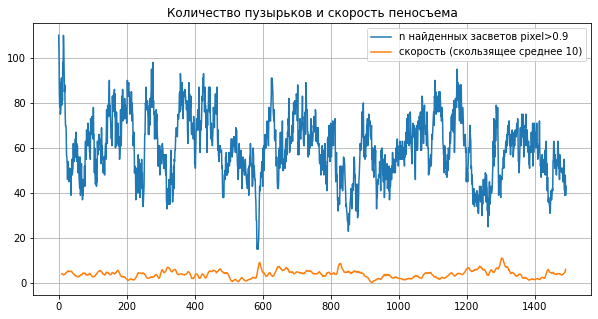

In [7]:
plt.figure(figsize=(10,5));
plt.plot(ts_ncenters)
#plt.plot(vels)
plt.plot(pd.Series(vels).rolling(window=10).mean())
plt.title('Количество пузырьков и скорость пеносъема')
plt.legend(['n найденных засветов pixel>0.9', 'скорость (скользящее среднее 10)'])
plt.grid()
plt.show()

Начальная картинка:


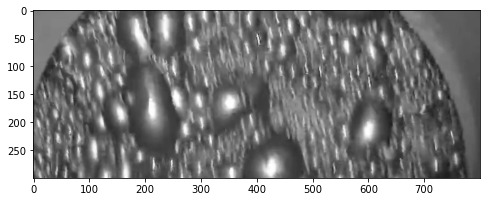

Картинка с найденными бликами:


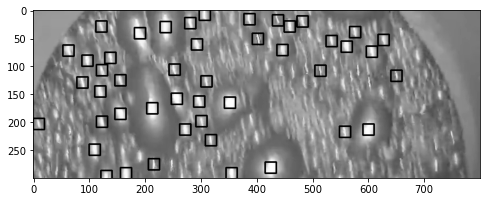

In [37]:
see_centers(frames[1001])

## Создание демо-видео:

In [9]:
# .mp4
out = cv2.VideoWriter('velocity_{}.mp4'.format(name),
                      cv2.VideoWriter_fourcc(*'DIVX'),
                      30,
                      (frames[0].shape[1],frames[1].shape[0]))

for i in range(len(vels)):
    v = vels[i]
    d = dirs[i]
    n = ts_ncenters[i]
    shot = frames[i].copy()
    start_point = (frames[0].shape[1]//2, frames[0].shape[0]//2)
    end_point = (frames[0].shape[1]//2+dirs[i][0]*7, frames[0].shape[0]//2+dirs[i][1]*7)
    cv2.line(shot, start_point, end_point, 255, 5)
    cv2.rectangle(shot, (0,0), (100,40), 255, 50)
    cv2.rectangle(shot, (0,40), (100,80), 255, 50)
    
    #cv2.putText(image, text, org, font, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
    cv2.putText(img=shot,
                text='v={}'.format(v),
                org=(5,40),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 1, color = (0, 0, 0),
                thickness=2)
    
    cv2.putText(img=shot,
                text='n={}'.format(n),
                org=(5,80),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 1, color = (0, 0, 0),
                thickness=2)
    
    gray = cv2.normalize(shot, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    #see_plot(gray)
    gray_3c = cv2.merge([gray, gray, gray])
    out.write(gray_3c)
out.release()

In [6]:
# .avi
height = frames[-1].shape[0]
width = frames[-1].shape[1]
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 30
video_filename = 'velocity_{}.avi'.format(name)
out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

for i in range(len(vels)):
    v = vels[i]
    d = dirs[i]
    shot = frames[i].copy()
    start_point = (frames[0].shape[1]//2, frames[0].shape[0]//2)
    end_point = (frames[0].shape[1]//2+dirs[i][0]*7, frames[0].shape[0]//2+dirs[i][1]*7)
    cv2.line(shot, start_point, end_point, 255, 4)
    
    gray = cv2.normalize(shot, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    gray_3c = cv2.merge([gray, gray, gray])
    out.write(gray_3c)
out.release()